In [1]:
import geopandas as gpd
import pandas as pd
import scipy.stats as stats
import shapely
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from libpysal import graph
from scipy.spatial import distance

import preprocess_data

In [2]:
buildings, levels = preprocess_data.get_buildings("/data/uscuni-ulce/boundaries_of_change/classification/")

In [3]:
gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg")

,name,geometry_type
0,1240_mongol_invasion,Polygon
1,900_political,Polygon
2,1000_political,Polygon
3,1300_ostsiedlung,Polygon
4,1550_religion,Polygon
5,1526_political,Polygon
6,1618_political,Polygon
7,1648_political,Polygon
8,1600_religion,Polygon
9,1812_political,Polygon


In [4]:
boundary_list = list(gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg").name)
boundary_list.remove("1812_political") #to be fixed
boundary_list.remove("1900_germans") #to be fixed
boundary_list.remove("1300_ostsiedlung") #to be fixed

<Axes: >

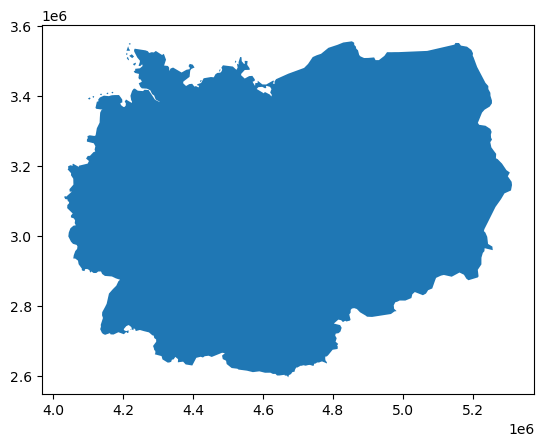

In [5]:
aoi = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer="1994_political")
aoi = aoi.dissolve()
aoi.plot()

In [6]:
layer_of_interest = boundary_list[-1]

In [7]:
building_counts = preprocess_data.get_building_counts_per_region(buildings, gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=layer_of_interest))

In [8]:
normalized_building_counts = preprocess_data.normalize_building_counts(building_counts)

In [9]:
normalized_building_counts

level_4,1.0,2.0,3.0,4.0,5.0,6.0,7.0
NAME,,,,,,,
Austria,0.090186,0.066871,0.067601,0.211758,0.161411,0.356275,0.045898
Czechia,0.175307,0.093758,0.024207,0.132315,0.199688,0.317318,0.057406
Germany,0.209462,0.016445,0.252617,0.316513,0.040499,0.119622,0.044842
Poland,0.042430,0.071380,0.032705,0.056683,0.461066,0.285646,0.050090
Slovakia,0.063721,0.010054,0.193626,0.248881,0.256522,0.133162,0.094033


In [10]:
def compute_bc_matrix(count_table):
    bray_curtis_dist = distance.pdist(count_table, metric='braycurtis')
    bray_curtis_matrix = distance.squareform(bray_curtis_dist)
    bray_curtis_df = pd.DataFrame(bray_curtis_matrix, index=count_table.T.columns, columns=count_table.T.columns)
    return bray_curtis_df

In [11]:
bray_curtis_matrix = compute_bc_matrix(normalized_building_counts)
bray_curtis_matrix

NAME,Austria,Czechia,Germany,Poland,Slovakia
NAME,,,,,
Austria,0.000000,0.161794,0.409047,0.308357,0.306395
Czechia,0.161794,0.000000,0.446762,0.269875,0.379446
Germany,0.409047,0.446762,0.000000,0.646774,0.278755
Poland,0.308357,0.269875,0.646774,0.000000,0.418353
Slovakia,0.306395,0.379446,0.278755,0.418353,0.000000


<Axes: xlabel='NAME', ylabel='NAME'>

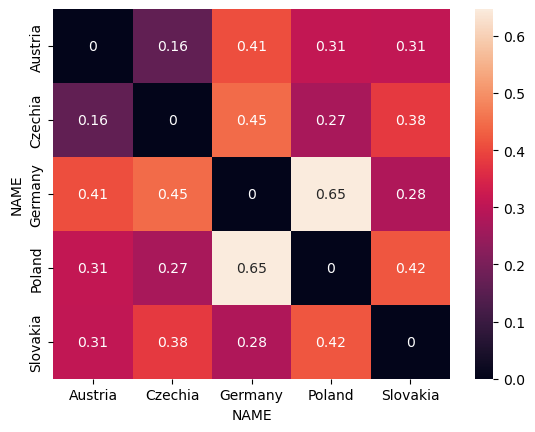

In [12]:
sns.heatmap(bray_curtis_matrix, annot=True)

In [13]:
def generate_bc_heatmaps_for_boundary(level_list, boundary_name):

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.flatten()
    
    for level, ax in zip(level_list, axs):
        bc = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{boundary_name}_{level}.pq')
        sns.heatmap(bc, annot=True, ax=ax)
        ax.set_title(level)

    fig.suptitle(boundary_name)
    fig.tight_layout()

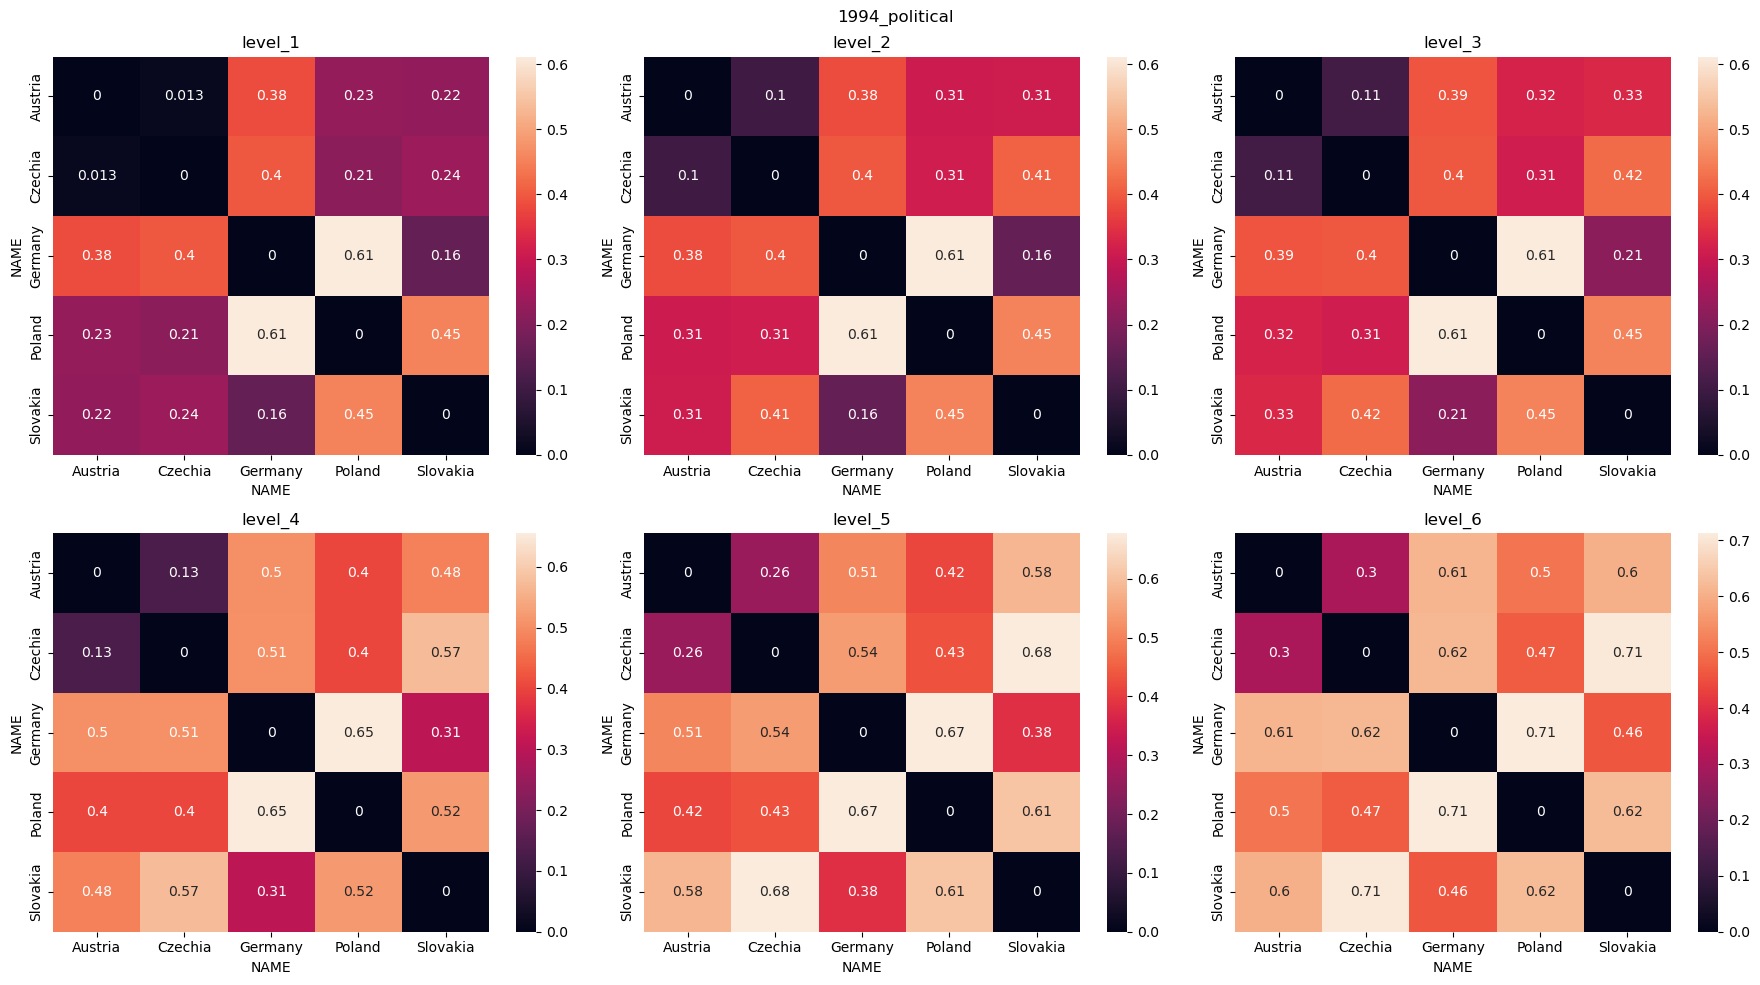

In [14]:
generate_bc_heatmaps_for_boundary(levels, layer_of_interest)

In [17]:
from tqdm import tqdm

def generate_bc_matrices(list_of_boundaries, level_list):
    for bnd in tqdm(list_of_boundaries, desc=f"Processing boundaries..."):
        boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=bnd)
        
        for level in tqdm(level_list, desc=f"Generating matrices for {bnd}"):
            building_counts = preprocess_data.get_building_counts_per_region(buildings, boundary, level)
            building_counts_norm = preprocess_data.normalize_building_counts(building_counts)
            
            bray_curtis_matrix = compute_bc_matrix(building_counts_norm)
            output_path = f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{bnd}_{level}.pq'
            bray_curtis_matrix.to_parquet(output_path)

In [ ]:
generate_bc_matrices(boundary_list, levels)

erating matrices for 1240_mongol_invasion:   0%|                                               | 0/7 [00:00<?, ?it/s]

In [ ]:
def generate_boundary_diagrams(boundary_lst):
    
    fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(20,10), sharex=True, sharey=True)
    axs = axs.flatten()
    
    for i, boundary in enumerate(boundary_list):
        boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=bnd)
        bray_curtis_matrix = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{bnd}_level_4.pq')

        
    for ax in axs:
        ax.set_axis_off()

In [ ]:
def generate_boundary_diagram(boundary_name, ax):
    boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=boundary_name)

    bray_curtis_matrix = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{boundary_name}_level_4.pq')
    
    indices = boundary.sindex.query(boundary.geometry, predicate="intersects")
    left, right = np.unique(np.sort(indices, axis=0), axis=1)

    mask = left == right
    left = left[~mask]
    right = right[~mask]
    geoms = boundary.iloc[left].intersection(boundary.iloc[right], align=False)
    left = boundary.NAME.iloc[left]
    right = boundary.NAME.iloc[right]
    border_widths = []
    for l, r in zip(left, right):
        border_widths.append(bray_curtis_matrix.loc[l, r])
        
    #alphas = [(4*(np.exp(2*a) - 1)) for a in border_widths]
    #alphas = [(a - min(alphas)) / (max(alphas) - min(alphas)) for a in alphas]
    border_widths = [(0.1 + 4*(np.exp(2*w) - 1)) for w in border_widths]
    norm=plt.Normalize(min(border_widths),max(border_widths))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightgray","black"])
    for geom, width in zip (geoms, border_widths):
        gpd.GeoSeries([shapely.line_merge(geom)]).plot(ax=ax, linewidth=width, color=cmap(norm(width)))
        # print(geom)
    ax.set_title(f"{boundary_name}")

In [ ]:
boundary_name = "1960_political"
boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=boundary_name)

bray_curtis_matrix = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{boundary_name}_level_4.pq')
    
indices = boundary.sindex.query(boundary.geometry, predicate="intersects")
left, right = np.unique(np.sort(indices, axis=0), axis=1)

mask = left == right
left = left[~mask]
right = right[~mask]
geoms = boundary.iloc[left].intersection(boundary.iloc[right], align=False)
left = boundary.NAME.iloc[left]
right = boundary.NAME.iloc[right]

border_widths = []
for l, r in zip(left, right):
    border_widths.append(bray_curtis_matrix.loc[l, r])
        
    #alphas = [(4*(np.exp(2*a) - 1)) for a in border_widths]
    #alphas = [(a - min(alphas)) / (max(alphas) - min(alphas)) for a in alphas]
border_widths = [(0.1 + 4*(np.exp(2*w) - 1)) for w in border_widths]

norm=plt.Normalize(min(border_widths),max(border_widths))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightgray","black"])
cmap

In [ ]:
norm(max(border_widths))

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
generate_boundary_diagram("1960_political", ax=ax)

In [ ]:
def generate_boundary_diagrams(boundary_lst):
    
    fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(20,10), sharex=True, sharey=True)
    axs = axs.flatten()
    #aoi.plot(ax=ax[0], color='lightgray')
    #aoi.plot(ax=ax[1], color='lightgray')
    #cmap = plt.get_cmap("tab20")
    #colors = {bnd: cmap(i) for i,bnd in enumerate(boundary_lst)}
    
    for i, boundary in enumerate(boundary_list):
        aoi.plot(ax=axs[i], color='lightgray')
        generate_boundary_diagram(boundary, ax=axs[i])

    plt.tight_layout()
        #print(bnd)
        #boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=bnd)
        #bray_curtis_matrix = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{bnd}_level_4.pq')

        #indices = boundary.sindex.query(boundary.geometry, predicate="intersects")
        #left, right = np.unique(np.sort(indices, axis=0), axis=1)

        #mask = left == right
        #left = left[~mask]
        #right = right[~mask]
        #geoms = boundary.iloc[left].intersection(boundary.iloc[right], align=False)
        #left = boundary.NAME.iloc[left]
        #right = boundary.NAME.iloc[right]

        #border_widths = []

        #for l, r in zip(left, right):
        #    border_widths.append(bray_curtis_matrix.loc[l, r])
            
        #alphas = [(4*(np.exp(2*a) - 1)) for a in border_widths]
        #alphas = [(a - min(alphas)) / (max(alphas) - min(alphas)) for a in alphas]
        #border_widths = [(0.1 + 4*(np.exp(2*w) - 1)) for w in border_widths]

        #from matplotlib.patches import Patch
        #patches_legend = [Patch(facecolor=colors[bnd], label=bnd) for bnd in boundary_lst]

        #for geom, width, alpha in zip (geoms, border_widths, alphas):
        #    gpd.GeoSeries([geom]).plot(ax=ax[0], linewidth=width, color=colors[bnd], alpha=alpha)
        #    ax[0].legend(handles=patches_legend)


        #    gpd.GeoSeries([geom]).plot(ax=ax[1], linewidth=width, color="black", alpha=alpha)
            #ax.legend(handles=patches_legend)
    for ax in axs:
        ax.set_axis_off()

In [ ]:

generate_boundary_diagrams(boundary_list)

In [ ]:
generate_bc_matrices(boundary_list, level_columns)

## Draw borders

In [ ]:
for bnd in boundary_list:
    boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=bnd)
    joined = gpd.sjoin(buildings, boundary, how="left", predicate="within")
    generate_bc_heatmaps_for_boundary(level_columns, bnd)

In [ ]:
indices = boundaries.sindex.query(boundaries.geometry, predicate="intersects")
left, right = np.unique(np.sort(indices, axis=0), axis=1)

mask = left == right
left = left[~mask]
right = right[~mask]
geoms = boundaries.iloc[left].intersection(boundaries.iloc[right], align=False)
left = boundaries.NAME.iloc[left]
right = boundaries.NAME.iloc[right]

geoms.plot(cmap='tab20')

In [ ]:
geoms

In [ ]:
bray_curtis_matrix.loc[left.iloc[0],right.iloc[0]]

In [ ]:
geoms = gpd.GeoDataFrame(geometry=geoms)

In [ ]:
border_widths = []

for l, r in zip(left, right):
    border_widths.append(bray_curtis_matrix.loc[l, r])


In [ ]:
geoms["width"] = [np.sqrt(w) for w in border_widths]
geoms

In [ ]:
widths = (geoms.width - geoms.width.min()) / (geoms.width.max() - geoms.width.min())

geoms["map_width"] = widths
geoms

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
aoi.plot(ax=ax, color='lightgray')

geoms.plot(ax=ax, linewidth=geoms["map_width"], color='red')

## Principal Coordinates visualization

In [ ]:
from skbio.stats.ordination import pcoa
from skbio.stats.distance import DistanceMatrix

In [ ]:
pcoa_res = pcoa(DistanceMatrix(bray_curtis_matrix, ids=cnt_table_norm.columns))

In [ ]:
pcoa_res_df = pd.DataFrame(pcoa_res.samples.iloc[:, :2], index=cnt_table_norm.columns)

In [ ]:
pcoa_res_df

In [ ]:
sns.scatterplot(x="PC1", y="PC2", hue=pcoa_res_df.index, data=pcoa_res_df, s=100)